In [1]:
from src.plot_utils import *
from pathlib import Path
import json
from scipy import stats

dir_Qmax7 = Path('../results/run_Qmax7_onlyUrban_0506_1359_seed824956/')
dir_Qmin7 = Path('../results/run_Qmin7_onlyUrban_0506_1357_seed220973/')

Qmin7Fname = '../data/Qmin7_final_dataset_seasonal4.pkl'
Qmax7Fname = '../data/Qmax7_final_dataset_seasonal4.pkl'

par_map = pd.read_csv('../data/predictors.csv')

with open(dir_Qmax7 / 'cfg.json', 'r') as fp:
    cfg = json.load(fp)
    
mode = cfg['mode']
predictors = cfg['meteo_name'] + cfg['lulc_name'] + cfg['attr_name']
log = cfg['log']
m3s = cfg['m3s']
feature = cfg['feature']
model = cfg['model']
featureName = par_map.loc[par_map.par==feature,'name'].values[0]

with open(dir_Qmin7 / 'cfg.json', 'r') as fp:
    cfg_Qmin7 = json.load(fp)
cfg_Qmax7 = cfg

delta_feature = int(cfg_Qmax7['delta_feature'])

Qmin7Fname = dir_Qmin7 / f'{model}_{mode}_sensitivity_func_+0{delta_feature}{feature}_diff_in_percentage.csv'
Qmax7Fname = dir_Qmax7 / f'{model}_{mode}_sensitivity_func_+0{delta_feature}{feature}_diff_in_percentage.csv'

diff_Qmin7 = pd.read_csv(Qmin7Fname)
diff_Qmax7 = pd.read_csv(Qmax7Fname)

diff_Qmin7['Qmin7date'] = pd.to_datetime(diff_Qmin7['Qmin7date'])
diff_Qmax7['Qmax7date'] = pd.to_datetime(diff_Qmax7['Qmax7date'])

diff_Qmin7 = pd.read_pickle(cfg_Qmin7['fname']).merge(diff_Qmin7, on = ['ohdb_id','Qmin7date'])
diff_Qmax7 = pd.read_pickle(cfg_Qmax7['fname']).merge(diff_Qmax7, on = ['ohdb_id','Qmax7date'])

import pymannkendall as mk
def func(x):
    diff = x['diff'].mean()
    p = stats.ttest_1samp(x['diff'].values, 0, alternative='two-sided').pvalue
    x0 = x[['year','ImperviousSurface']].drop_duplicates().sort_values('year')
    mk0 = mk.original_test(x0.ImperviousSurface.values)
    slope = mk0.slope
    slope_p = mk0.p
    ave = x0.ImperviousSurface.mean()
    
    ohdb_id = x.ohdb_id.values[0]
    tmp = pd.read_csv(f'../data_mswx/mswx_each_basin/{ohdb_id}_1981-2023.csv')
    smrz_median = tmp.rolling(7).smrz.median()
    evap_median = tmp.rolling(7).evap.median()
    smrz_anomaly = (x.smrz - smrz_median).mean()
    evap_anomaly = (x.evap - evap_median).mean()
    
    out = pd.Series([diff,p,slope,slope_p,ave,smrz_anomaly,evap_anomaly], index = [
        'diff','p','slope','slope_p','urban_ave','smrz_anomaly','evap_anomaly'])
    return out

diff_Qmin7_ave = diff_Qmin7.groupby(['ohdb_longitude','ohdb_latitude','climate_label','aridity']).p_apply(func).reset_index()
diff_Qmax7_ave = diff_Qmax7.groupby(['ohdb_longitude','ohdb_latitude','climate_label','aridity']).p_apply(func).reset_index()


FUNC DONE:   0%|          | 0/8619 [00:00<?, ?it/s]

FUNC DONE:   0%|          | 0/8618 [00:00<?, ?it/s]

### sensitivity at Colombia

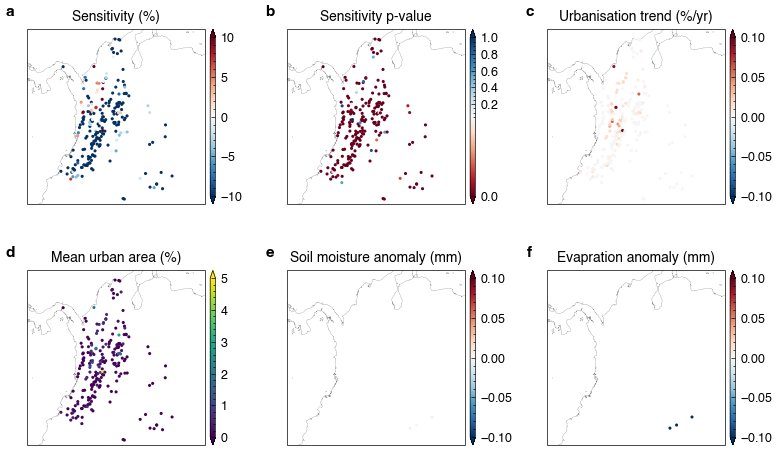

In [4]:
import string
df = diff_Qmax7_ave
df1 = df.loc[(df.ohdb_longitude>=-82)&(df.ohdb_longitude<=-65)&(df.ohdb_latitude>=-1)&(df.ohdb_latitude<=12),:]

fig, axes = plt.subplots(2, 3, figsize = (8, 5), subplot_kw = {'projection':ccrs.EqualEarth()})
for i,name in enumerate(['diff', 'p', 'slope', 'urban_ave', 'smrz_anomaly', 'evap_anomaly']):
    ax = axes.ravel()[i]
    ax.set_extent([-82, -65, -1, 12], crs=ccrs.PlateCarree())
    ax.coastlines(lw = .1)
    if name in ['slope','smrz_anomaly','evap_anomaly']:
        norm = mpl.colors.TwoSlopeNorm(vmin = -0.1, vmax = 0.1, vcenter = 0)
        cmap = plt.cm.RdBu_r
    elif name == 'diff':
        norm = mpl.colors.TwoSlopeNorm(vmin = -10, vmax = 10, vcenter = 0)
        cmap = plt.cm.RdBu_r
    elif name == 'urban_ave':
        norm = mpl.colors.Normalize(vmin = 0, vmax = 5)
        cmap = plt.cm.viridis
    elif name == 'p':
        norm = mpl.colors.TwoSlopeNorm(vmin = 0, vmax = 1, vcenter = 0.05)
        cmap = plt.cm.RdBu
    lons = df1.ohdb_longitude.values
    lats = df1.ohdb_latitude.values
    vals = df1[name].values
    size = 20
    marker = '.'
    ras = ax.scatter(lons, lats, c = vals, norm = norm, cmap = cmap, s = size, marker = marker, 
                    ec = "face", transform = ccrs.PlateCarree(), zorder = 3, linewidths = 0)
    # add colorbar
    cax = ax.inset_axes([1.03, 0, 0.03, 1])
    cbar = plt.colorbar(ras, cax = cax, extend = 'both')
    cax.tick_params(labelsize = 9)
    
    if name == 'diff':
        name2 = 'Sensitivity (%)'
    elif name == 'p':
        name2 = 'Sensitivity p-value'
    elif name == 'slope':
        name2 = 'Urbanisation trend (%/yr)'
    elif name == 'urban_ave':
        name2 = 'Mean urban area (%)'
    elif name == 'smrz_anomaly':
        name2 = 'Soil moisture anomaly (mm)'
    elif name == 'evap_anomaly':
        name2 = 'Evapration anomaly (mm)'
    ax.set_title(name2, fontsize = 10)
    ax.text(-.1, 1.1, string.ascii_letters[i], fontsize = 11, weight = 'bold', ha = 'center', va = 'center', transform = ax.transAxes)
fig.tight_layout()
fig.savefig('colombia_test.png', dpi = 600)

<Axes: xlabel='urban', ylabel='ImperviousSurface'>

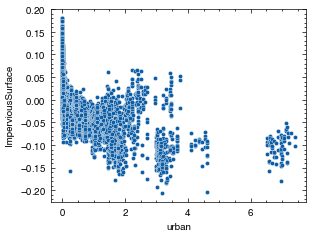

In [6]:
import pickle
fname = dir_Qmax7 / 'xgb_onlyUrban_shap_values_explain_103650.pkl'
shap0 = pickle.load(open(fname,'rb'))
df0 = pd.DataFrame(data = shap0, columns = predictors)
tmp = pd.read_pickle(cfg_Qmax7['fname']).rename(columns={'ohdb_longitude':'lon','ohdb_latitude':'lat','ImperviousSurface':'urban'})
df0 = pd.concat([df0, tmp[['ohdb_id','lon','lat','urban']]], axis = 1)
df0 = df0.loc[(df0.lon>=-82)&(df0.lon<=-65)&(df0.lat>=-5)&(df0.lat<=12),:]
sns.scatterplot(df0, x = 'urban', y = 'ImperviousSurface')